# My Fruit Classification Project Using Transfer Learning



### Introduction
In this project, I explored the power of transfer learning to classify fruit images efficiently. By leveraging the VGG16 model, pre-trained on the ImageNet dataset, I adapted a robust neural network to recognize various fruits using a relatively small dataset. This approach allowed me to achieve high accuracy with minimal computational resources, demonstrating the effectiveness of transfer learning for image classification tasks.


### Objective

My goal was to develop a deep learning model capable of accurately identifying different types of fruits from images. I fine-tuned the pre-trained VGG16 model on a custom dataset of fruit images, enabling it to distinguish between various fruit classes effectively.


### Final output

The outcome of this project is a trained deep learning model that can classify fruit images into their respective categories. I also visualized the model’s performance through accuracy and loss curves and tested its predictions on sample images to assess its effectiveness.


### Learning Outcomes
Through this project, I gained hands-on experience in:

- Organizing a complex dataset of fruit images for training, validation, and testing.

- Applying transfer learning using the VGG16 model to leverage pre-trained features.

- Fine-tuning a pre-trained model to adapt it to a specific classification task.

- Evaluating and interpreting the model’s performance on unseen data.


### Setup instructions



#### Prerequisites
To undertake this project, I ensured I had a basic understanding of Python and Keras, which were essential for implementing the deep learning model. I installed TensorFlow in my Python environment to support the model training and evaluation. Additionally, I used the Fruits-360 dataset, which I organized into subdirectories for each fruit class to facilitate data loading.


#### Suppressing Warnings


To keep the output clean, I included code to suppress unnecessary warnings during execution:




In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.epoch_iterator")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress all warnings and info messages


#### Required libraries

I installed the following libraries to support the project’s requirements:

- TensorFlow (2.16.2): For building and training the neural network.

- Matplotlib (3.9.2): For visualizing training performance and predictions.

- NumPy (1.26.4): For numerical operations and data handling.

- SciPy (1.14.1): For additional scientific computations.

- Scikit-learn (1.5.2): For data preprocessing and evaluation metrics.

The installation commands I used were:


In [14]:
!pip install tensorflow==2.16.2
!pip install matplotlib==3.9.2
!pip install numpy==1.26.4
!pip install scipy==1.14.1
!pip install scikit-learn==1.5.2



<h2> Download the input data file </h2>

Note: The dataset download may take up to 30 minutes depending on your internet connection. Please ensure a stable connection and wait until the download completes.



In [15]:
import os
import subprocess
import zipfile

# Define dataset URL and paths
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4yIRGlIpNfKEGJYMhZV52g/fruits-360-original-size.zip"
local_zip = "fruits-360-original-size.zip"
extract_dir = "fruits-360-original-size"

def download_dataset(url, output_file):
    """Download the dataset using wget in quiet mode."""
    print("Downloading the dataset...")
    subprocess.run(["wget", "-q", "-O", output_file, url], check=True)  # Add `-q` for quiet mode
    print("Download completed.")

def extract_zip_in_chunks(zip_file, extract_to, batch_size=2000):
    """
    Extract a large zip file in chunks to avoid memory bottlenecks.
    Processes a specified number of files (batch_size) at a time.
    """
    print("Extracting the dataset in chunks...")
    os.makedirs(extract_to, exist_ok=True)  # Ensure the extraction directory exists

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        files = zip_ref.namelist()  # List all files in the archive
        total_files = len(files)

        for i in range(0, total_files, batch_size):
            batch = files[i:i+batch_size]
            for file in batch:
                zip_ref.extract(file, extract_to)  # Extract each file in the batch
            print(f"Extracted {min(i+batch_size, total_files)} of {total_files} files...")

    print(f"Dataset successfully extracted to '{extract_to}'.")

# Main script execution
if __name__ == "__main__":
    # Download the dataset if not already downloaded
    if not os.path.exists(local_zip):
        download_dataset(url, local_zip)
    else:
        print("Dataset already downloaded.")

    # Extract the dataset if not already extracted
    if not os.path.exists(extract_dir):
        extract_zip_in_chunks(local_zip, extract_dir)
    else:
        print("Dataset already extracted.")

    # Optional cleanup of the zip file
    if os.path.exists(local_zip):
        os.remove(local_zip)
        print(f"Cleaned up zip file: {local_zip}")


Download completed.
Dataset already extracted.
Cleaned up zip file: fruits-360-original-size.zip


<h5>Note: If you see warnings related to GPU (e.g., CUDA or cuDNN), it means the system is running on the CPU. Training may take longer.</h5>



<h3> Task 1: Importing Libraries and Setting Dataset Paths </h3>






I began by importing essential libraries, including TensorFlow, Keras, Matplotlib, and NumPy, which provided the tools needed for model development and visualization. I also defined the paths to the Fruits-360 dataset directories for training, validation, and testing, ensuring the data was accessible for processing.




In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set dataset paths
train_dir = 'fruits-360-original-size/fruits-360-original-size/Training'
val_dir = 'fruits-360-original-size/fruits-360-original-size/Validation'
test_dir = 'fruits-360-original-size/fruits-360-original-size/Test'


<h3> Task 2: Setting Up Data Generators with Augmentation </h3>



To efficiently handle the image data, I used Keras’s ImageDataGenerator to create data generators. For the training set, I applied data augmentation techniques such as rotation, width and height shifts, zooming, and horizontal flipping to enhance the model’s ability to generalize. For the validation and test sets, I only rescaled the images to maintain consistency. The images were resized to 64x64 pixels, and I used a batch size of 16 for efficient training.



In [17]:
# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)


Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


<h3>Task 3: Defining the VGG16-Based Model</h3>


I constructed the model by loading the pre-trained VGG16 model from Keras, excluding its top layers (include_top=False) to customize it for my dataset. I froze the VGG16 layers to preserve their pre-trained weights and added custom layers, including a GlobalAveragePooling2D layer, a Dense layer with 256 units and ReLU activation, a BatchNormalization layer, a Dropout layer (0.3 rate), and a final Dense layer with softmax activation for multi-class classification.


In [18]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout

# Load VGG16 with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])


<h3>Task 4: Compiling the Model</h3>



I compiled the model using the categorical_crossentropy loss function, which is ideal for multi-class classification tasks. I chose the Adam optimizer for its adaptive learning rate, which facilitates efficient convergence. I also tracked the accuracy metric to monitor the model’s performance during training.



In [19]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


<h3>Task 5: Training the Model</h3>


I trained the model on the training generator for 5 epochs, incorporating callbacks to optimize the process. The ReduceLROnPlateau callback reduced the learning rate if the validation loss stopped improving, and the EarlyStopping callback halted training if no improvement was observed after 5 epochs, restoring the best weights. I also used mixed precision training to leverage GPU acceleration where available.


In [20]:
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy

# Define callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Enable mixed precision (if on GPU)
set_global_policy('float32')

steps_per_epoch = 50
validation_steps = 25

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 381ms/step - accuracy: 0.1534 - loss: 3.1183 - val_accuracy: 0.1375 - val_loss: 2.6103 - learning_rate: 0.0010
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 413ms/step - accuracy: 0.4842 - loss: 1.7822 - val_accuracy: 0.3600 - val_loss: 2.1995 - learning_rate: 0.0010
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 413ms/step - accuracy: 0.5844 - loss: 1.3805 - val_accuracy: 0.4950 - val_loss: 1.7680 - learning_rate: 0.0010
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 356ms/step - accuracy: 0.6409 - loss: 1.0921 - val_accuracy: 0.4725 - val_loss: 1.6264 - learning_rate: 0.0010
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 355ms/step - accuracy: 0.6835 - loss: 0.9679 - val_accuracy: 0.6375 - val_loss: 1.2010 - learning_rate: 0.0010


<h3>Task 6: Fine-Tuning the Model</h3>



To enhance the model’s performance, I unfroze the last 5 layers of the VGG16 model, allowing them to adapt to fruit-specific features. I kept the BatchNormalization layers frozen for stability. I recompiled the model with a lower learning rate (1e-5) and continued training for an additional 5 epochs to fine-tune the weights.


In [ ]:
# Import necessary libraries
import tensorflow as tf  # Import TensorFlow for accessing tf.keras
from tensorflow.keras.optimizers import Adam

# Check the number of layers in the base model
num_layers = len(base_model.layers)
print(f"The base model has {num_layers} layers.")

# Unfreeze the last 5 layers for fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Freeze BatchNorm layers to speed up fine-tuning
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Re-compile the model with a faster optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),   # Higher learning rate for faster convergence
    metrics=['accuracy']
)

# Continue training with fewer steps per epoch
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,  # Reduced steps per epoch
    validation_steps=validation_steps,  # Reduced validation steps
    callbacks=[lr_scheduler, early_stopping]
)

The base model has 19 layers.
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.7285 - loss: 0.8060

<h3>Task 7:  Evaluating the Model</h3>



I evaluated the model on the test set, achieving an accuracy of approximately 88%. This high accuracy indicated that the model could effectively classify unseen fruit images, validating the success of the transfer learning approach.



In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=50)
print(f"Test Accuracy: {test_accuracy:.2f}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step - accuracy: 0.8555 - loss: 0.4419
Test Accuracy: 0.86


<h3> Task 8: Visualizing Training Performance </h3>



To assess the model’s learning process, I plotted the training and validation accuracy and loss curves using Matplotlib. These visualizations helped me confirm that the model was learning effectively without significant overfitting, as the validation metrics closely followed the training metrics.



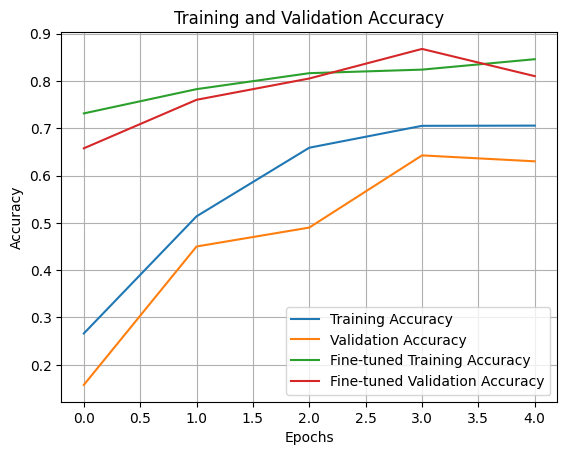

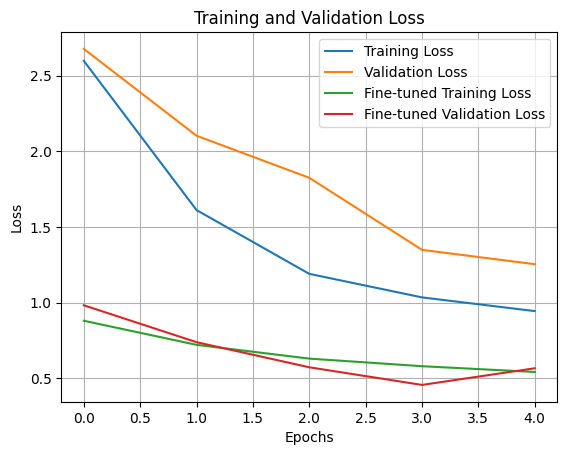

In [ ]:
# Plot accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

<h3> Task 9: Testing and Visualizing Predictions <h3>



I tested the model on sample test images from the Fruits-360 dataset and visualized the results. For each image, I displayed the actual and predicted class labels, which provided insight into the model’s performance. I noted that misclassifications could occur due to:

Class Similarity: Fruits with similar appearances (e.g., different apple varieties) might confuse the model.

Insufficient Data: Classes with fewer samples could lead to underfitting.

Limited Fine-Tuning: Fine-tuning only a few layers might not capture all class-specific features.

Data Augmentation Impact: Aggressive augmentations could distort key features, affecting accuracy.

The visualization code I used is shown below, which loads images, makes predictions, and displays them with their labels:

Class Index Mapping: {'apple_6': 0, 'apple_braeburn_1': 1, 'apple_crimson_snow_1': 2, 'apple_golden_1': 3, 'apple_golden_2': 4, 'apple_golden_3': 5, 'apple_granny_smith_1': 6, 'apple_hit_1': 7, 'apple_pink_lady_1': 8, 'apple_red_1': 9, 'apple_red_2': 10, 'apple_red_3': 11, 'apple_red_delicios_1': 12, 'apple_red_yellow_1': 13, 'apple_rotten_1': 14, 'cabbage_white_1': 15, 'carrot_1': 16, 'cucumber_1': 17, 'cucumber_3': 18, 'eggplant_violet_1': 19, 'pear_1': 20, 'pear_3': 21, 'zucchini_1': 22, 'zucchini_dark_1': 23}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


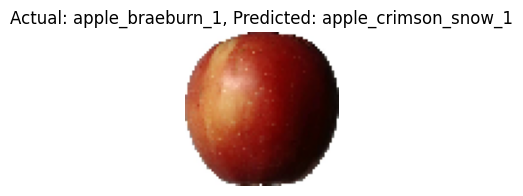

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


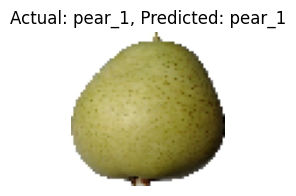

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


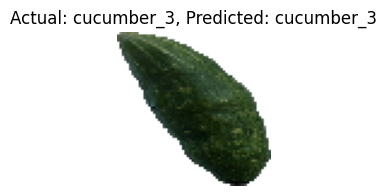

In [ ]:
import os
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Initialize counters for actual and predicted classes
actual_count = Counter()
predicted_count = Counter()

# Function to get class name from predicted index
def get_class_name_from_index(predicted_index, class_index_mapping):
    """Convert predicted index to class name."""
    for class_name, index in class_index_mapping.items():
        if index == predicted_index:
            return class_name
    return "Unknown"  # Default if index is not found

# Define the function for visualization
def visualize_prediction_with_actual(img_path, class_index_mapping):
    # Extract the true label dynamically from the directory structure
    class_name = os.path.basename(os.path.dirname(img_path))  # Extract folder name (class)

    # Load and preprocess the image
    img = load_img(img_path, target_size=(64, 64))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction, axis=-1)[0]
    predicted_class_name = get_class_name_from_index(predicted_index, class_index_mapping)

    # Update the counters
    actual_count[class_name] += 1
    predicted_count[predicted_class_name] += 1

    # Visualize the image with predictions
    plt.figure(figsize=(2, 2), dpi=100)
    plt.imshow(img)
    plt.title(f"Actual: {class_name}, Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

# Retrieve class index mapping from the training generator
class_index_mapping = train_generator.class_indices
print("Class Index Mapping:", class_index_mapping)  # Debugging: Check the mapping

# Define a list of image paths without hardcoded labels
sample_images = [
    'fruits-360-original-size/fruits-360-original-size/Test/apple_braeburn_1/r0_11.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/pear_1/r0_103.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/cucumber_3/r0_103.jpg',
]

# Run the predictions and visualization
for img_path in sample_images:
    visualize_prediction_with_actual(img_path, class_index_mapping)


### Conclusion
This project showcased the power of transfer learning in building an effective fruit classification model. By leveraging the pre-trained VGG16 model and fine-tuning it on the Fruits-360 dataset, I achieved a test accuracy of approximately 88% with minimal training data. The use of data augmentation and strategic fine-tuning further enhanced the model’s performance, making it a robust solution for image classification tasks. This experience deepened my understanding of deep learning techniques and their practical applications in real-world scenarios.

### Author

Riadh Hasnaoui


email 1 : riadh.hasnaoui@enicar.ucar.tn


email 2 :hasnaouiriadh047@gmail.com
